In [68]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.io import loadmat,savemat
from os import system

In [80]:
# Weight matrix generation function
# mode = 0  k-1-param1-k-param1-k+1   k-2-param2-k-param2-k+2
# mode = 1  SmallWorld param1 = K param2 = rewire param3 = w
def generate_matrix(mode,N,param1,param2,param3,wfilename):
    mat = np.zeros((N,N))
    if mode==0:
        for i in range(N):
            for j in range(N):
                if abs(i-j)==1:
                    mat[i][j]=param1
                elif abs(i-j)==2:
                    mat[i][j]=param2
    elif mode==1:
        mat = nx.to_numpy_array(nx.watts_strogatz_graph(N,param1,param2))*param3
        print(N,param1,param2,param3)
    np.savetxt("Weights/{}.txt".format(wfilename),mat,fmt='%.3f')
    
# Raster Loading and splitting
def load_raster(N,filename):
    raster = np.zeros((N,100000))
    with open("Rasters/{}.txt".format(filename)) as O:
        lc = 0
        for line in O:
            raster[lc,list(map(int,line.strip().split()))]=1
            lc+=1
    return raster

def save_matlab(N,M,infilename,outfilename):
    raster = load_raster(N,infilename)
    subraster = raster[np.random.choice(range(N),M,replace=False),:]
    plt.figure(figsize=(25,3)) #plot
    plt.imshow(subraster,aspect="auto")
    plt.show()
    savemat("MatlabRasters/{}.mat".format(outfilename),{"binnedSpikes":subraster})
    print("Ajustar('MatlabRasters','MaxEntParams','{}.mat');".format(outfilename))


def run_matlab(filename):
    system("""matlab -nodisplay -nosplash -nodesktop -r "cd('MaxEntCode');Ajustar('../MatlabRasters','../MaxEntParams','{}.mat');exit()" """.format(filename))
    
def load_params(N,infilename):
    ising = loadmat("MaxEntParams/{}.mat".format(infilename))
    params = ising["params"] # N , N*(N-1)/2
    J = np.zeros((N,N)) #FullMatrix for indexing
    J[np.triu_indices(N, 1)] = params[:,0][N:] #UpperTri Matrix
    H = params[:,0][:N] #<h,sigma>
    return H,J
    
    

25 4 0.2 0.2


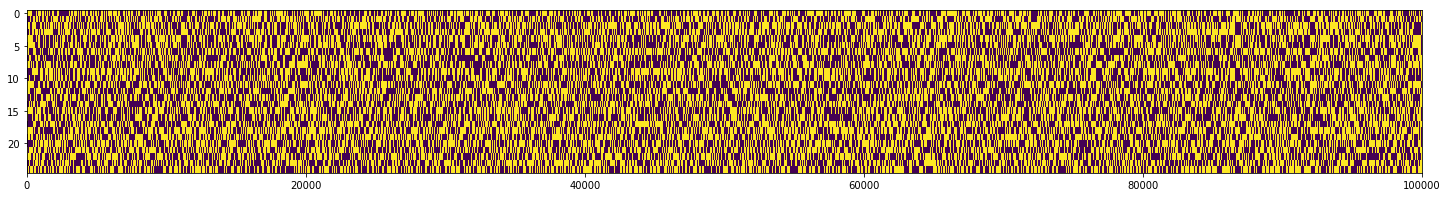

Ajustar('MatlabRasters','MaxEntParams','nuevo2.mat');


In [ ]:
# Testing
def run_everything(wfilename,outfilename):
    generate_matrix(1,25,4,0.2,0.2,wfilename) #generate weight matrix
    system("./BMS 25 Weights/{}.txt Rasters/{}.txt".format(wfilename,outfilename)) #generates raster from weight matrix to outfilename
    ras=load_raster(25,outfilename) #loads raster from outfilename
    plt.figure(figsize=(25,3)) #plot
    plt.imshow(ras,aspect="auto")
    plt.show()
    save_matlab(25,20,outfilename,outfilename) #creates a sub-raster matlab file
    run_matlab(outfilename) #runs matlab maxent over the subraster
    h,j = load_params(20,outfilename) #gets maxent params from the subraster model
    print (h)
    print (j)
run_everything("matriz1","nuevo2")

In [ ]:
# Standard Workflow
wfilename = "smallworld"
rastername = "N100SW"
N = 100
generate_matrix(1,N,4,0.2,0.2,wfilename)
system("./BMS {} Weights/{}.txt Rasters/{}.txt".format(N,wfilename,rastername))
params = []
for n in [20,40]:
    subrastername = rastername+"x{}".format(n)
    save_matlab(N,n,rastername,subrastername)
    run_matlab(subrastername)
    params.append(load_params(n,subrastername))

## Notes

Run time of N=80 ~ 30min